In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter

from data.dataset import dataset_qtt
from linsolve.cg import ConjGrad
from linsolve.precond import llt_prec_trig_solve, llt_inv_prec
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot, CorrectionNet, ShiftNet

from utils import jBCOO_to_scipyCSR, params_count, asses_cond, iter_per_residual, batch_indices
from data.utils import direc_graph_from_linear_system_sparse
from train import train

plt.rcParams['figure.figsize'] = (11, 7)

# Setup experiment

In [90]:
pde = 'div_k_grad'      # 'poisson', 'div_k_grad'
grid = 32            # 32, 64, 128
variance = .5        # 0.1, 0.5, 1.0 1.5
lhs_type = 'fd'      # 'fd', 'ilu0', 'ilu1', 'ilu2', 'ict', 'l_ict', 'a_pow'
N_train = 1000
N_test = 200


fill_factor = 1     # int
threshold = 1e-4     # float
power = 2            # int
N_valid_CG = 100     # Number of CG iterations for validation in the very end

# Make dataset

In [91]:
s1 = perf_counter()
A_test, _, b_test, u_exact_test, bi_edges_test = dataset_qtt(pde, grid, variance, lhs_type, return_train=False, N_samples=N_test, fill_factor=fill_factor, threshold=threshold, power=power)
print(perf_counter() - s1)

0.11538399010896683


In [92]:
def inverse_set(A):
    A_inv = [jnp.linalg.inv(A[i, ...].todense())[None, ...] for i in range(A.shape[0])]
    return jnp.concat(A_inv, axis=0)

In [93]:
A_inv = inverse_set(A_test)

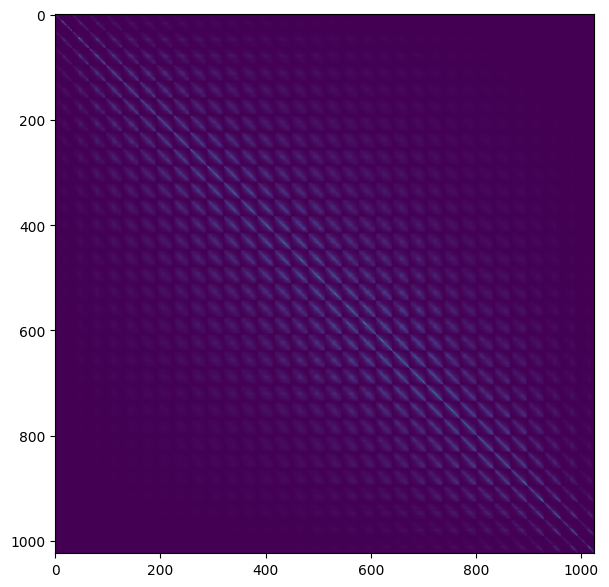

In [94]:
plt.imshow(A_inv[0, ...]);

In [95]:
import scipy

def diag_pattern(A_inv, A):
    P = []
    for i in range(A_inv.shape[0]):
        P.append(jnp.diag(jnp.diag(A_inv[i, ...], k=0), k=0)[None, ...])
    return jnp.concat(P, axis=0)

def diag_dominant_pattern(A_inv, A, k=1):
    assert k > 0 
    P = []
    for i in range(A_inv.shape[0]):
        P_i = jnp.diag(jnp.diag(A_inv[i, ...], k=0), k=0)
        for j in range(k):
            P_i = P_i + jnp.diag(jnp.diag(A_inv[i, ...], k=j), k=j) + jnp.diag(jnp.diag(A_inv[i, ...], k=-j), k=-j)
        P.append(P_i[None, ...])
    return jnp.concat(P, axis=0)

def power_pattern(A_inv, A, power=1, strict=False):
    assert power >= 1 
    P = []
    A_local = A
    if strict:
        A_local.data = A_local.data * 0 + 1
        
    for i in range(A.shape[0]):
        A_i_csr = jBCOO_to_scipyCSR(A_local[i, ...])
        A_inv_i = A_inv[i, ...].copy()
        
        pattern = scipy.sparse.linalg.matrix_power(A_i_csr, power).tocoo()
        P_i = jnp.zeros_like(A_inv_i)
        P_i = P_i.at[pattern.row, pattern.col].set(
            A_inv_i.at[pattern.row, pattern.col].get()
        )
        P.append(P_i[None, ...])
    return jnp.concat(P, axis=0)

def product_patern(A_inv, A, power=1, strict=False):
    assert power >= 1 
    P = []
    A_local = A
    if strict:
        A_local.data = A_local.data * 0 + 1

    for i in range(A.shape[0]):
        A_i_csr = jBCOO_to_scipyCSR(A_local[i, ...])
        A_inv_i = A_inv[i, ...].copy()

        pattern = (scipy.sparse.linalg.matrix_power(A_i_csr.T @ A_i_csr, power) @ A_i_csr.T).tocoo()
        P_i = jnp.zeros_like(A_inv_i)
        P_i = P_i.at[pattern.row, pattern.col].set(
            A_inv_i.at[pattern.row, pattern.col].get()
        )
        P.append(P_i[None, ...])
    return jnp.concat(P, axis=0)

def sum_pattern(A_inv, A, power=1, strict=False):
    assert power >= 1 
    P = []
    A_local = A
    if strict:
        A_local.data = A_local.data * 0 + 1

    for i in range(A.shape[0]):
        A_i_csr = jBCOO_to_scipyCSR(A_local[i, ...])
        A_inv_i = A_inv[i, ...].copy()
        A_i_csr_abs = A_i_csr.copy()
        A_i_csr_abs.data = np.abs(A_i_csr_abs.data)
        
        pattern = (scipy.sparse.linalg.matrix_power(scipy.sparse.eye(A.shape[1]) + A_i_csr_abs + A_i_csr_abs.T, power) @ A_i_csr.T).tocoo()
        P_i = jnp.zeros_like(A_inv_i)
        P_i = P_i.at[pattern.row, pattern.col].set(
            A_inv_i.at[pattern.row, pattern.col].get()
        )
        P.append(P_i[None, ...])
    return jnp.concat(P, axis=0)

# Some experiments with inverse

In [155]:
A_csr = jBCOO_to_scipyCSR(A_test[0, ...])

In [156]:
A_csr.T @ A_csr

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 12676 stored elements and shape (1024, 1024)>

In [185]:
def matrix_power_my(A, n):
    return scipy.sparse.linalg.matrix_power(A, n)

68.77884615384616


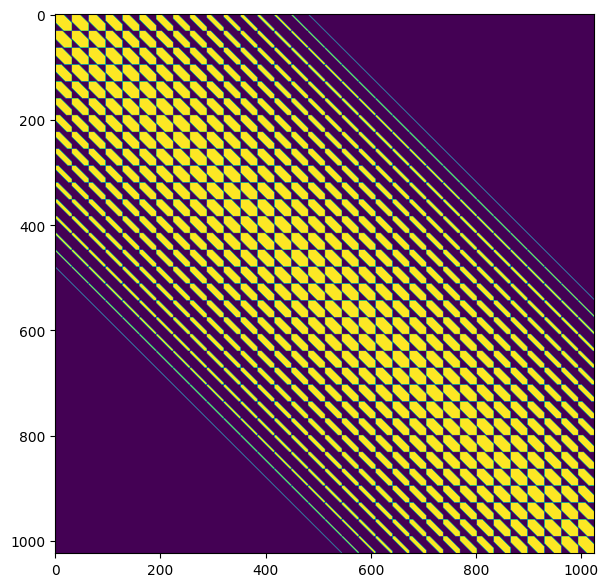

In [186]:
A_ = jBCOO_to_scipyCSR(A_test[0, ...])

A_2 = matrix_power_my(A_, 15)
A_2.data = A_2.data * 0 + 1
plt.imshow(A_2.todense());
print(A_2.nnz / A_.nnz)

9.374237060546875


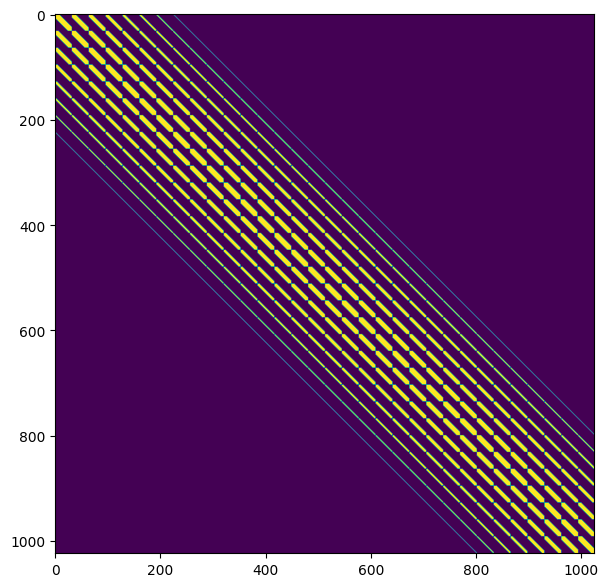

In [64]:
A_csr = jBCOO_to_scipyCSR(A_test[0, ...])
A_csr = matrix_power_my(A_csr.T @ A_csr, 3) @ A_csr.T

A_csr.data = A_csr.data * 0 + 1
print((A_csr.nnz * 100) / (A_csr.shape[0]**2))
plt.imshow(A_csr.todense());

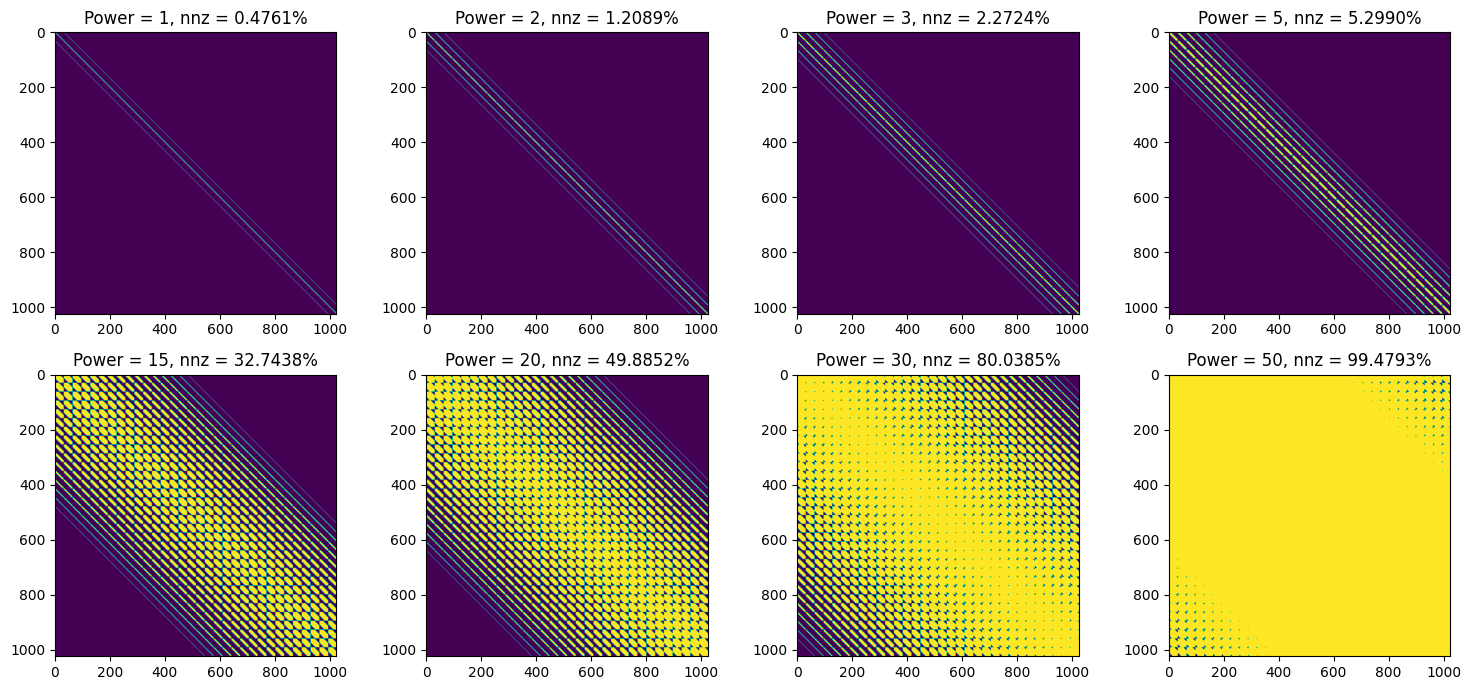

In [191]:
fig, axes = plt.subplots(2, 4, figsize=(15,7))
axes = axes.flatten()

power_ls = [1, 2, 3, 5, 15, 20 ,30, 50]

for i, p in enumerate(power_ls):
    A_ = jBCOO_to_scipyCSR(A_test[0, ...])

    A_2 = scipy.sparse.linalg.matrix_power(A_, p)
    A_2.data = A_2.data * 0 + 1
    axes[i].imshow(A_2.todense())
    axes[i].set_title(f'Power = {p}, nnz = {A_2.nnz * 100 / A_2.shape[0]**2:.4f}%')
    
plt.tight_layout();

# Make precs

In [96]:
P_diag = diag_pattern(A_inv, A_test)

In [97]:
P_diag_1 = diag_dominant_pattern(A_inv, A_test, k=1)
P_diag_2 = diag_dominant_pattern(A_inv, A_test, k=2)
P_diag_3 = diag_dominant_pattern(A_inv, A_test, k=3)

P_diag_5 = diag_dominant_pattern(A_inv, A_test, k=5)
P_diag_10 = diag_dominant_pattern(A_inv, A_test, k=10)
P_diag_15 = diag_dominant_pattern(A_inv, A_test, k=15)
P_diag_30 = diag_dominant_pattern(A_inv, A_test, k=30)
P_diag_50 = diag_dominant_pattern(A_inv, A_test, k=50)
P_diag_100 = diag_dominant_pattern(A_inv, A_test, k=100)

In [98]:
P_pow_1 = power_pattern(A_inv, A_test, power=1, strict=False)
P_pow_2 = power_pattern(A_inv, A_test, power=2, strict=False)
P_pow_3 = power_pattern(A_inv, A_test, power=3, strict=False)
P_pow_5 = power_pattern(A_inv, A_test, power=5, strict=False)

In [149]:
P_pow_15 = power_pattern(A_inv, A_test, power=15, strict=False)

In [161]:
P_pow_20 = power_pattern(A_inv, A_test, power=20, strict=False)
P_pow_30 = power_pattern(A_inv, A_test, power=30, strict=False)

In [192]:
P_pow_50 = power_pattern(A_inv, A_test, power=50, strict=False)

In [99]:
P_sum_1 = sum_pattern(A_inv, A_test, power=1, strict=False)
P_sum_2 = sum_pattern(A_inv, A_test, power=2, strict=False)
P_sum_3 = sum_pattern(A_inv, A_test, power=3, strict=False)

In [131]:
P_sum_10 = sum_pattern(A_inv, A_test, power=10, strict=False)

In [138]:
P_sum_50 = sum_pattern(A_inv, A_test, power=50, strict=False)

In [193]:
P_ls = [
    A_inv,
#     P_diag, 
#     P_diag_1,
#     P_diag_2,
#     P_diag_3,
#     P_diag_5,
#     P_diag_10,
#     P_diag_15,
#     P_diag_30,
#     P_diag_50,
#     P_diag_100,
    P_pow_1,
    P_pow_2,
    P_pow_3,
    P_pow_5,
#     P_sum_1,
#     P_sum_2,
#     P_sum_3,
#     P_sum_10,
    P_pow_15,
    P_pow_20,
    P_pow_30,
    P_pow_50,
]

names_ls = [
    'A_inv',
#     'P_diag', 
#     'P_diag_1',
#     'P_diag_2',
#     'P_diag_3',
#     'P_diag_5',
#     'P_diag_10',
#     'P_diag_15',
#     'P_diag_30',
#     'P_diag_50',
#     'P_diag_100',
    'P_pow_1',
    'P_pow_2',
    'P_pow_3',
    'P_pow_5',
#     'P_sum_1',
#     'P_sum_2',
#     'P_sum_3',
#     'P_sum_10',
    'P_pow_15',
    'P_pow_20',
    'P_pow_30',
    'P_pow_50',
]

In [101]:
def apply_prec(res, P, *args):
    return vmap(lambda P_, res_: P_ @ res_, in_axes=(0, 0), out_axes=(0))(P, res)

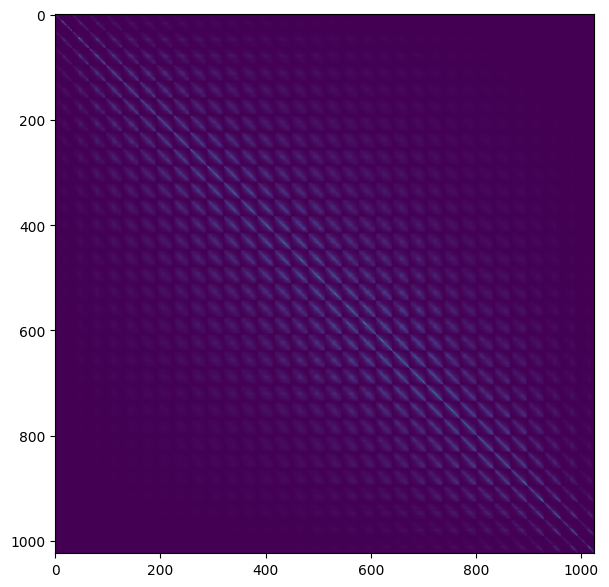

In [140]:
plt.imshow(A_inv[0, ...])

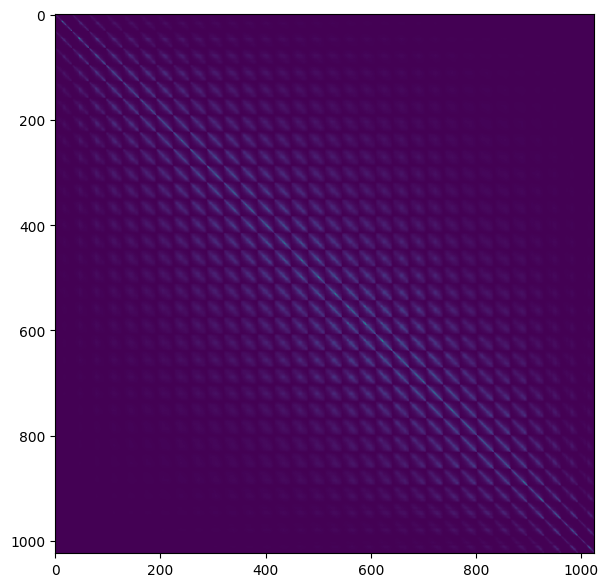

In [141]:
plt.imshow(P_sum_50[0, ...])

In [142]:
norm_error = lambda A_, x_, b_: vmap(lambda A, x, b: jnp.linalg.norm(A @ x - b) / jnp.linalg.norm(b), in_axes=(0, 0, 0), out_axes=(0))(A_, x_, b_)
norm_error_inv = lambda A_inv_, x_, b_: vmap(lambda A_inv, x, b: jnp.linalg.norm(x - A_inv @ b) / jnp.linalg.norm(b), in_axes=(0, 0, 0), out_axes=(0))(A_inv_, x_, b_)

In [194]:
for R_j, name in zip(P_ls, names_ls):
    print(name)
    print(norm_error_inv(R_j, u_exact_test, b_test).mean(), '+-', norm_error_inv(R_j, u_exact_test, b_test).std())

A_inv
2.186888e-08 +- 1.4280914e-08
P_pow_1
0.0017957762 +- 0.0007214742
P_pow_2
0.0016673678 +- 0.00069051905
P_pow_3
0.0015396507 +- 0.000649311
P_pow_5
0.0013054284 +- 0.000549871
P_pow_15
0.0004898536 +- 0.00014608947
P_pow_20
0.00026862163 +- 6.98042e-05
P_pow_30
6.1732884e-05 +- 1.550008e-05
P_pow_50
4.3423992e-07 +- 1.6032598e-07


In [126]:
print('A_inv')
print(norm_error_inv(A_inv, u_exact_test, b_test).mean(), '+-', norm_error_inv(A_inv, u_exact_test, b_test).std())

A_inv
2.186888e-08 +- 1.4280914e-08


In [127]:
print('Solution')
print(norm_error(A_test, u_exact_test, b_test).mean(), '+-', norm_error(A_test, u_exact_test, b_test).std())

Solution
6.78342e-07 +- 2.8500585e-07


# Apply model to CG

In [180]:
# Not preconditioned
N_valid_CG = 200
X_I, R_I = ConjGrad(A_test, b_test, N_iter=N_valid_CG, prec_func=None, seed=42)

In [195]:
X_ls, R_ls, t_ls = [], [], []
for P_i in P_ls:
    appl_prec = partial(apply_prec, P=P_i)
    s_prec = perf_counter()
    X_LLT, R_LLT = ConjGrad(A_test, b_test, N_iter=N_valid_CG, prec_func=appl_prec, seed=42)
    t_ls.append(perf_counter() - s_prec)
    X_ls.append(X_LLT)
    R_ls.append(R_LLT)

In [196]:
# print(A_pad_test.shape)
# a = A_pad_test[0, :100, :100]
# a.data = a.data * 0 + 1
# plt.imshow(a.todense())

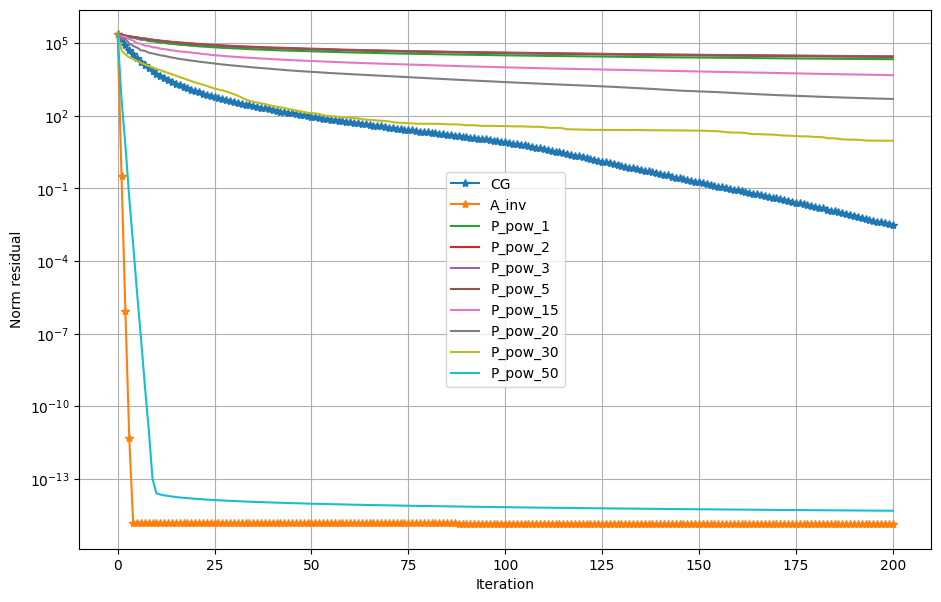

In [198]:
# _, axes = plt.subplots(3, 1, figsize=(11, 11))

# for ax in axes:
#     ax.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="CG")
#     ax.plot(range(R_ls[0].shape[-1]), jnp.linalg.norm(R_ls[0], axis=1).mean(0), label="A_inv")

# for R_j, name in zip(R_ls[1:6], names_ls[1:6]):
#     axes[0].plot(range(R_j.shape[-1]), jnp.linalg.norm(R_j, axis=1).mean(0), label=name)

# for R_j, name in zip(R_ls[6:12], names_ls[6:12]):
#     axes[1].plot(range(R_j.shape[-1]), jnp.linalg.norm(R_j, axis=1).mean(0), '--', label=name)
    
# for R_j, name in zip(R_ls[12:], names_ls[12:]):
#     axes[2].plot(range(R_j.shape[-1]), jnp.linalg.norm(R_j, axis=1).mean(0), '-*', label=name)

# for ax in axes:
#     ax.set_xlabel('Iteration')
#     ax.set_ylabel('Norm residual')
#     ax.legend();
#     ax.set_yscale('log')
#     ax.grid();


plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), '-*', label="CG")
plt.plot(range(R_ls[0].shape[-1]), jnp.linalg.norm(R_ls[0], axis=1).mean(0), '-*', label="A_inv")

for R_j, name in zip(R_ls[1:], names_ls[1:]):
    plt.plot(range(R_j.shape[-1]), jnp.linalg.norm(R_j, axis=1).mean(0), label=name)

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();
# res_I_dict = iter_per_residual(jnp.linalg.norm(R_I, axis=1).mean(0))
# res_LLT_dict = iter_per_residual(jnp.linalg.norm(R_LLT, axis=1).mean(0))
# print(' CG:', res_I_dict)
# print('PCG:', res_LLT_dict)

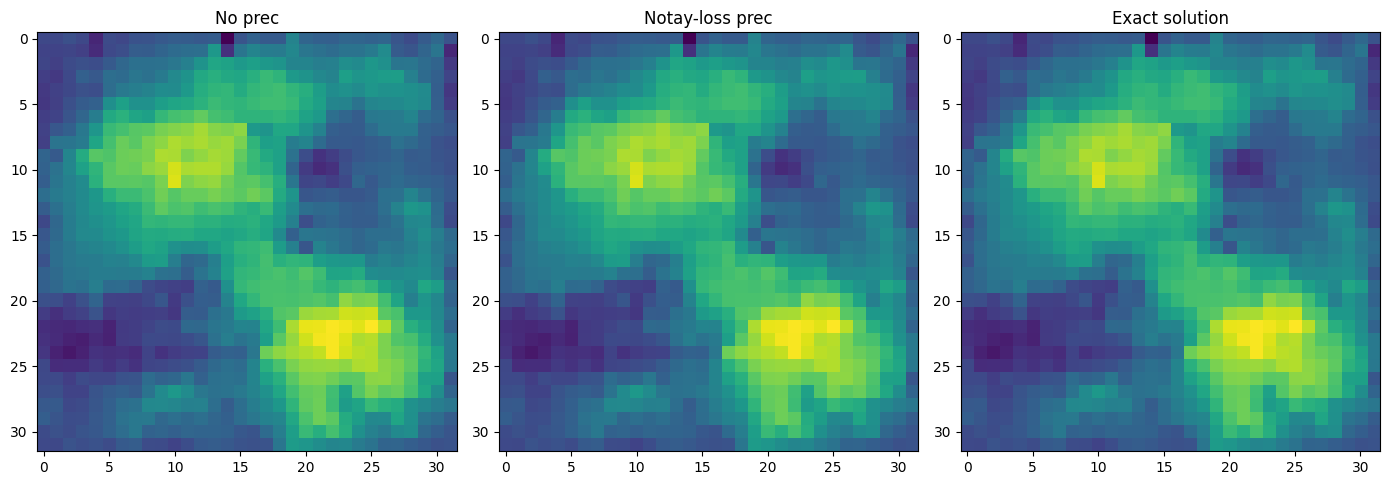

In [178]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()